In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai
from tqdm import tqdm_notebook as tqdm

In [3]:
from fastai.vision import *

In [4]:
from pathlib import Path

In [5]:
from skimage.io import imread,imshow,imsave

In [6]:
import warnings
from collections import defaultdict

In [7]:
path_img = Path('../train')

# create balaced train and valid datasets

In [8]:
import pandas as pd

In [9]:
df = pd.read_csv('../train.csv')

In [10]:
#create a balanced test dataset
    #1) to balance test ds, i need statistics of train ds distribution
        #1) equal number of defects based on type?
# lets go with a random split of train dataset and establish the pipeline

In [11]:
# every image has atleast one pattern, weird who the fuck created this data set?!!!

### every file has atleast one cloud pattern

In [12]:
lbl_dir = Path('../fish/lbl_fish')
data_dir = Path('../fish/data')
tst_dir = Path('../test')

In [13]:
# not to be used for training, as tfm_y is absent
data1 = (SegmentationItemList.from_folder(data_dir)
        #.filter_by_rand(0.01)
       .split_by_rand_pct()
       .label_from_func(lambda l:lbl_dir/(l.stem+".png"),classes=['bg','fish'])
        #.add_test(get_image_files(tst_dir))
       .transform(get_transforms(), tfm_y=True,size=(350,525))
       .databunch(bs=8)
       .normalize(stats=imagenet_stats))

In [26]:
_ = data1.train_ds[2]

In [30]:
data1.train_ds

LabelList (2225 items)
x: SegmentationItemList
Image (3, 1400, 2100),Image (3, 1400, 2100),Image (3, 1400, 2100),Image (3, 1400, 2100),Image (3, 1400, 2100)
y: SegmentationLabelList
ImageSegment (1, 1400, 2100),ImageSegment (1, 1400, 2100),ImageSegment (1, 1400, 2100),ImageSegment (1, 1400, 2100),ImageSegment (1, 1400, 2100)
Path: ../fish/data

In [14]:
from torch import tensor
from fastai.metrics import dice

## check current valid ds ka distibution

In [98]:
df[df.ImageId_ClassId == '135a4b191.jpg'+'_'+str(n)]['EncodedPixels'].values[0]

nan

In [108]:
dist = defaultdict(lambda : [])
for fl in learn.data.valid_ds.items:
    for n in [1,2,3,4]:
        if not pd.isna(df[df.ImageId_ClassId == fl.name+'_'+str(n)]['EncodedPixels'].values[0]):
            dist[n].append(fl.name)

In [109]:
len(learn.data.valid_ds.items)

2513

In [115]:
len(dist[1]),len(dist[2]),len(dist[3]),len(dist[4])

(180, 53, 1037, 144)

# get learner

In [15]:
learn = unet_learner(data1, models.resnet18,pretrained=True,metrics=dice, wd=0.01, bottle=True).to_fp16()

In [35]:
learn.load('wednesday11');

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


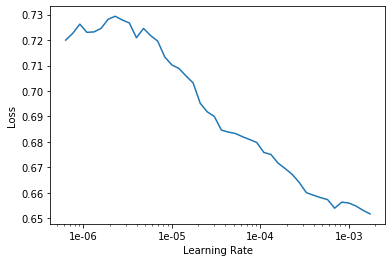

In [15]:
learn.recorder.plot()

In [16]:
learn.fit(1, 0.0001)

epoch,train_loss,valid_loss,dice,time
0,0.518743,0.490861,0.340502,02:55


In [22]:
learn.fit(1, 0.00001)

epoch,train_loss,valid_loss,dice,time
0,0.063206,0.058760,0.845512,05:36


In [31]:
learn.unfreeze()

In [24]:
learn.fit(1, slice(0.00001))

epoch,train_loss,valid_loss,dice,time
0,0.055905,0.054021,0.866510,05:53


In [30]:
learn.fit(3, 0.0001)

epoch,train_loss,valid_loss,dice,time
0,0.041293,0.042421,0.911214,05:15
1,0.043089,0.042855,0.886818,05:17
2,0.041897,0.041321,0.906110,05:16


In [33]:
pth = learn.save('../full_sz_run',return_path=True);
pth

PosixPath('train_images/models/../full_sz_run.pth')

In [32]:
learn.fit(3, slice(0.0001))

epoch,train_loss,valid_loss,dice,time
0,0.045370,0.046019,0.911815,05:29
1,0.045164,0.045753,0.900613,05:33
2,0.044614,0.046074,0.905555,05:32


In [47]:
learn.fit(5, 0.0001)

epoch,train_loss,valid_loss,dice,time
0,0.037841,0.043486,0.912111,03:21
1,0.040844,0.045663,0.911570,03:23
2,0.039179,0.043483,0.918054,03:23
3,0.039237,0.043990,0.915964,03:23
4,0.038802,0.046151,0.914322,03:23


In [63]:
learn.fit(5, 0.0033)

epoch,train_loss,valid_loss,dice,time
0,nan,nan,0.860923,03:18
1,nan,nan,0.860923,03:19
2,nan,nan,0.860923,03:18


Traceback (most recent call last):
  File "/home/ravi/miniconda3/envs/fastpy3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ravi/miniconda3/envs/fastpy3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ravi/miniconda3/envs/fastpy3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
Traceback (most recent call last):
  File "/home/ravi/miniconda3/envs/fastpy3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ravi/miniconda3/envs/fastpy3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ravi/miniconda3/envs/fastpy3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ravi/miniconda3/envs/fastpy3/lib/python3.7/multiprocessing/conne

KeyboardInterrupt: 

In [80]:
learn.fit(5, 0.001)

epoch,train_loss,valid_loss,time
0,0.092363,0.087214,04:43
1,0.108129,0.086938,04:50
2,0.101161,0.085588,04:49
3,0.101419,0.085457,04:46
4,0.091898,0.087555,04:48


# get test distirbution

In [28]:
def_counts = {1:0,2:0,3:0,4:0}
def_fls = {1:[],2:[],3:[],4:[]}
for fl in learn.data.valid_ds.items:
    for i in [1,2,3,4]:
        if not pd.isna(df[df.ImageId_ClassId==fl.name+'_'+str(i)][df.columns[1]].values[0]):
            def_counts[i] += 1
            def_fls[i].append(fl)

In [29]:
def_counts

{1: 180, 2: 56, 3: 1054, 4: 163}

In [33]:
len(def_fls[4])

163

# get dice score per class

In [ ]:
class TempDS(Dataset):
    def __init__(self,items):
        super().__init__()
        self.items = items
    
    def __getitem__(self,index):
        fl = self.items[index]
        img = imread(fl)
        msk = imread(lbl_dir/(fl.stem+'.png'))
        return img,msk

In [ ]:
learn.pred_batch()

In [320]:
pth = learn.save('../best_save_13eps',return_path=True);
pth

PosixPath('train_images/models/../best_save_13eps.pth')

In [248]:
learn.data.train_ds.items[11]

PosixPath('train_images/d11130898.jpg')

In [166]:
xt,yt = learn.data.test_ds[16]

In [167]:
yp = learn.predict(xt)

In [168]:
yt

EmptyLabel 

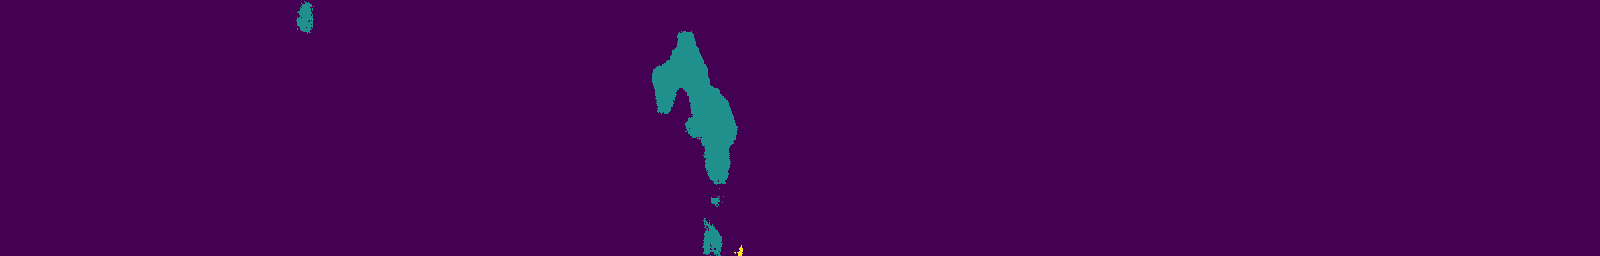

In [169]:
yp[0]

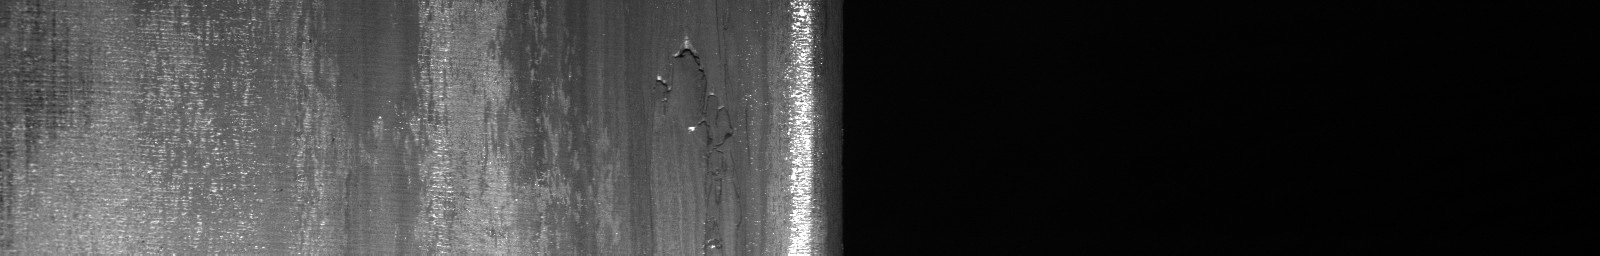

In [170]:
xt

In [171]:
torch.unique(torch.unique(yp[0].data))

tensor([0, 1, 2])

In [43]:
xt1,yt1 = learn.data.train_ds[1979]

In [44]:
yp1 = learn.predict(xt1)

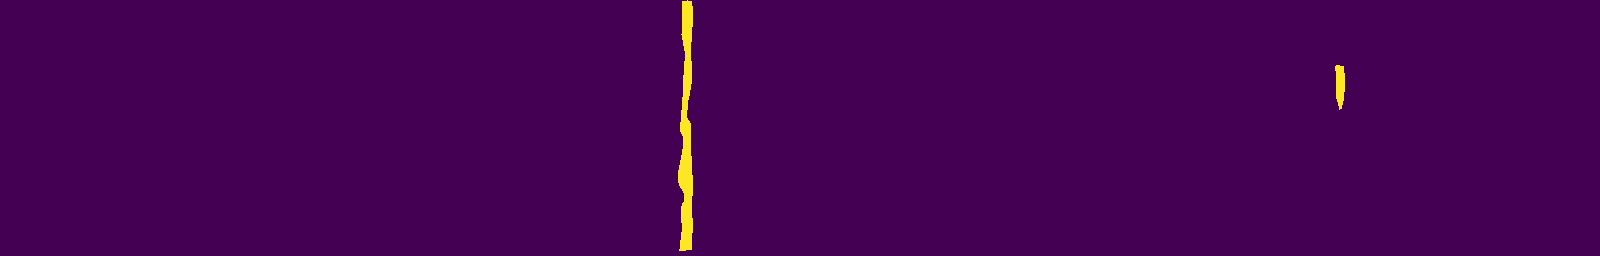

In [45]:
yt1

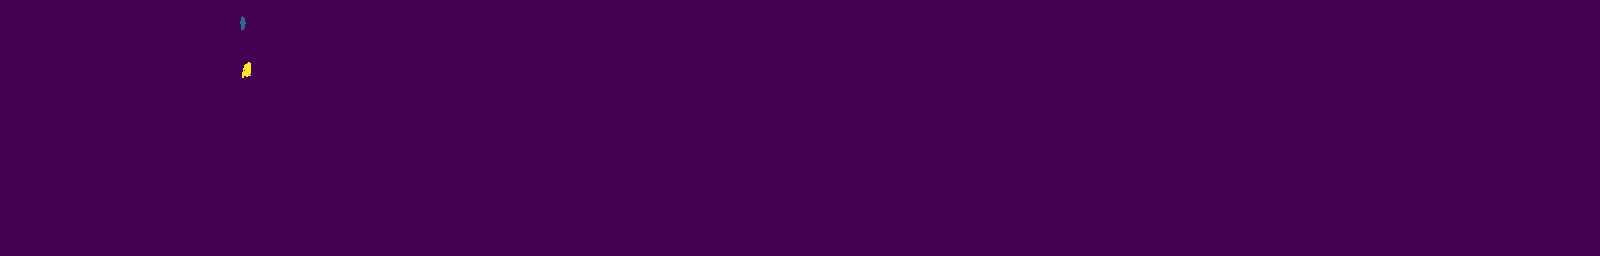

In [46]:
yp1[0]

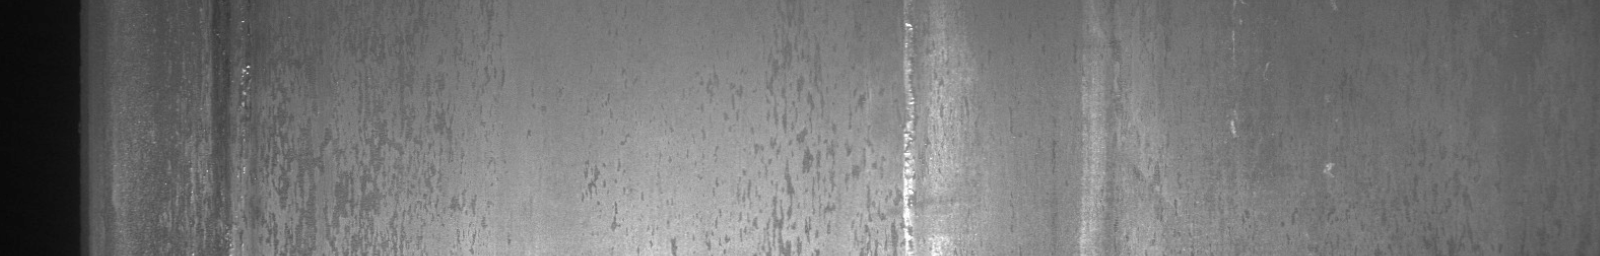

In [47]:
xt1

In [176]:
torch.unique(yp1[1]),torch.unique(yt1.data)

NameError: name 'yt1' is not defined

In [36]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [37]:
len(preds[0])

1801

In [38]:
preds[0][0].shape

torch.Size([5, 256, 1600])

In [38]:
from skimage.io import imshow

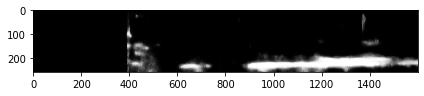

In [55]:
imshow(preds[0][1][3,:,:].numpy())

In [37]:
pp = learn.predict(learn.data.test_ds[1][0])[1].numpy().squeeze()

/home/ravi/miniconda3/envs/fastpy3/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


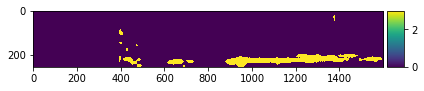

In [38]:
imshow(pp)

In [39]:
pr = np.round(preds[0][1][3,:,:].numpy())

In [40]:
np.unique(pr)

array([0., 1.], dtype=float32)

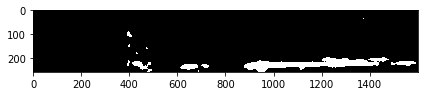

In [46]:
imshow(pr)

In [41]:
np.unique(pp)

array([0, 1, 3])

# save predictions masks

In [40]:
learn.data.test_ds.items[0]

PosixPath('test_images/6686b7448.jpg')

In [39]:
from skimage.io import imread

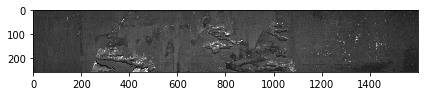

In [38]:
imshow(imread(learn.data.test_ds.items[19]))

In [40]:
preds_dir = Path('preds_full')

In [41]:
warnings.filterwarnings("ignore")

In [42]:
_ = preds[0][19].argmax(dim=0)

In [42]:
_.shape

torch.Size([256, 1600])

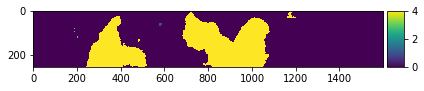

In [43]:
imshow(_.numpy())

In [44]:
np.unique(_.numpy())

array([0, 1, 3, 4])

In [43]:
for num,pred in tqdm(enumerate(preds[0])):
    #msk = np.zeros((256,1600),dtype=np.uint8)
    msk = np.argmax(pred.numpy(),axis=0).astype(np.uint8)
    for i in [1,2,3,4]:
        msk_ = (msk == i)
        if msk_.sum() < 50:
            msk[msk_] = 0
    #save mask
    imsave(preds_dir/(learn.data.test_ds.items[num].stem+".png"),msk)

In [50]:
np.unique(msk)

array([0, 1, 3], dtype=uint8)

In [99]:
__ = np.argmax(preds[0][12].numpy(),axis=0);
__.shape

(256, 1600)

In [100]:
np.unique(__)

array([0, 3, 4])

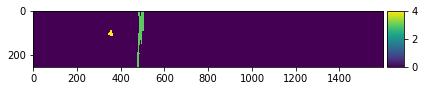

In [101]:
imshow(__)

In [102]:
learn.data.test_ds.items[12]

PosixPath('test_images/28ae995da.jpg')

In [7]:
import numpy as np

In [9]:
np.random.randint(0,4,size=(256,1600),dtype=np.uint8)

array([[3, 2, 2, 0, ..., 3, 0, 3, 2],
       [2, 0, 3, 3, ..., 3, 0, 0, 3],
       [2, 1, 2, 1, ..., 0, 1, 0, 2],
       [1, 0, 1, 1, ..., 1, 3, 2, 1],
       ...,
       [3, 3, 3, 0, ..., 3, 3, 2, 1],
       [2, 2, 0, 1, ..., 0, 2, 3, 3],
       [0, 0, 3, 0, ..., 0, 3, 3, 0],
       [3, 2, 3, 2, ..., 2, 1, 2, 2]], dtype=uint8)

In [ ]:
learn.model